In [1]:
%matplotlib inline
import time

# python 3
import urllib.error
from urllib.request import urlopen
import datetime
#from itertools import ifilter
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET

from bs4 import BeautifulSoup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import bibtexparser

pd.set_option('mode.chained_assignment','warn')

In [3]:
OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

def harvest(arxiv="physics:astro-ph", from_date="2016-08-01", until_date="2016-08-31"):
    """
    input: arxiv is the "set" defined in http://export.arxiv.org/oai2?verb=ListSets
    """
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords"
    url = (base_url +
           "&from=%s" % from_date +
           "&until=%s" % until_date + 
           "&metadataPrefix=arXiv&set=%s"%arxiv)
    
    while True:
        print("fetching", url)
        try:
            response = urlopen(url)
            
        except urllib.error.HTTPError as e:
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "&resumptionToken=%s"%(token.text)
    print("fetching finished.")
    return df
    

In [12]:
df = harvest(arxiv="physics:astro-ph", from_date="2016-01-01", until_date="2016-12-31")

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2016-01-01&until=2016-12-31&metadataPrefix=arXiv&set=physics:astro-ph
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|1001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|2001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|3001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|4001
Got 503. Retrying after 10 seconds.
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=3136987|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords

In [8]:
?pd.HDFStore

In [13]:
#store = pd.HDFStore("astroph_Aug2016.h5")
store = pd.HDFStore("astroph_2016.h5")

In [14]:
store.append('df', df)

TypeError: Cannot serialize the column [categories] because
its data contents are [mixed] object dtype

In [15]:
store['df'] = df
#df = store['df']

/home/wklee/anaconda3/envs/tf-gpu-2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['title', 'abstract', 'categories', 'id', 'doi']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
store.close()

In [17]:
ts = df['created'][0].to_pydatetime()

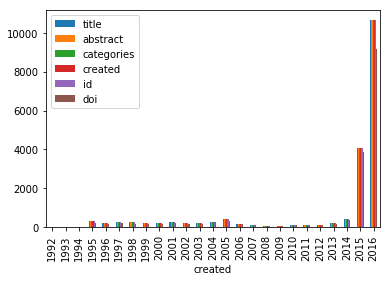

In [18]:
df.groupby(df["created"].dt.year).count().plot(kind="bar")

In [19]:
# assign label and remove those with sub-categories..
target_name_dict = { 'astro-ph.GA' : 0,
                     'astro-ph.SR' : 1,
                     'astro-ph.IM' : 2,
                     'astro-ph.EP' : 3,
                     'astro-ph.HE' : 4,
                     'astro-ph.CO' : 5
                   }

for i, rows in df.iterrows():
    cat = df.get_value(i, 'categories')
    if any(['astro-ph.' in c for c in cat]):
        for j in range(len(cat)):
            if cat[j] in target_name_dict.keys():
                label = target_name_dict[cat[j]]
#                print(i, label, cat)
                df.set_value(i, 'label', label)
                break
    else:
        df.drop(i, inplace=True)
        
# https://stackoverflow.com/questions/28885073/reindexing-after-pandas-drop-duplicates
df.reset_index(drop=True, inplace=True) # reset the index after dropping

/home/wklee/anaconda3/envs/tf-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/home/wklee/anaconda3/envs/tf-gpu-2/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


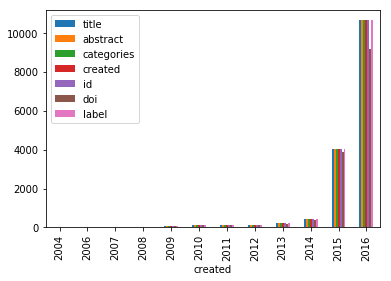

In [20]:
df.groupby(df["created"].dt.year).count().plot(kind="bar")

In [21]:
abstract = df['abstract'][100]

In [22]:
# remove string between $ $ 
# https://stackoverflow.com/questions/6857296/remove-contents-between-brackets-from-string
import re
abstract = re.sub(r'\$.*?\$', ' ', abstract)
abstract = re.sub(r'\n', ' ', abstract)

# remove punctuation in the abstract
# https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
import string
#translator1 = str.maketrans("", "", string.punctuation)
translator1 = str.maketrans(string.punctuation, " "*32)
translator2 = str.maketrans("", "", string.digits)
abstract = abstract.translate(translator1)
abstract = abstract.translate(translator2)

In [23]:
abstract

'We present comparison of numerical simulations of propagation of MHD waves excited by subphotospheric perturbations  in two different   deep  and  shallow   magnetostatic models of the sunspots  The  deep  sunspot model distorts both the shape of the wavefront and its amplitude stronger than the  shallow  model  For both sunspot models  the surface gravity waves  f mode  are affected by the sunspots stronger than the acoustic p modes  The wave amplitude inside the sunspot depends on the photospheric strength of the magnetic field and the distance of the source from the sunspot axis  For the source located at  Mm from the center of the sunspot  the wave amplitude increases when the wavefront passes through the central part of the sunspot  For the source distance of  Mm  the wave amplitude inside the sunspot is always smaller than outside  For the same source distance from the sunspot center but for the models with different strength of the magnetic field  the wave amplitude inside the 

In [24]:
Nabstract = len(df['abstract'])
print(Nabstract)

15842


In [27]:
import string
#translator1 = str.maketrans("", "", string.punctuation)
translator1 = str.maketrans(string.punctuation, " "*32)
translator2 = str.maketrans("", "", string.digits)

for i, rows in df.iterrows():
    abstract = df.abstract[i].lower()
    abstract = re.sub(r'\$.*?\$', ' ', abstract) # remove latex
    abstract = re.sub(r'\n', ' ', abstract) # remove end of line
    abstract = re.sub(r'x\-ray', 'xray', abstract) # replace x-ray by xray
    

    # remove punctuation in the abstract
    # https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
    abstract = abstract.translate(translator1)
    abstract = abstract.translate(translator2)
    
    # assign value back to dataFrame
    # https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
    #df.set_value(i, 'abstract', abstract)
    df.at[i, 'abstract'] = abstract
    

In [28]:
df.abstract[i]

'the emission of electromagnetic waves from a system described by the h  enon heiles potential is studied in this work  the main aim being to analyze the behavior of the system when the damping term is included explicitly into the equations of motion  energy losses at the chaotic regime and at the regular regime are compared  the results obtained here are similar to the case of gravitational waves emission  as long we consider only the energy loss  the main difference being that in the present work the energy emitted is explicitly calculated solving the equation of motion without further approximations  it is expected that the present analysis may be useful when studying the analogous problem of dissipation in gravitational systems '

In [29]:
#word_bag = " ".join(df.abstract.apply(lambda t: t.lower()))
word_bag = " ".join(df.abstract)

Counter(word_bag.split()).most_common(n=10)

[('the', 245575),
 ('of', 137076),
 ('and', 81750),
 ('a', 66478),
 ('in', 64379),
 ('to', 59944),
 ('we', 46727),
 ('is', 34780),
 ('with', 34721),
 ('that', 31699)]

In [32]:
from nltk.corpus import stopwords

stops = [word for word in stopwords.words('english')]
stops += ["=", "->"]
#words = filter(lambda w: w not in stops,
#               word_bag.split())
words = [word for word in word_bag.split() if word not in stops]
top_twenty = Counter(words).most_common(n=20)

In [33]:
top_twenty

[('mass', 11659),
 ('star', 8108),
 ('data', 8071),
 ('stars', 8052),
 ('model', 8037),
 ('galaxies', 7791),
 ('high', 7208),
 ('field', 6893),
 ('using', 6831),
 ('emission', 6794),
 ('observations', 6735),
 ('find', 6569),
 ('also', 6271),
 ('stellar', 6264),
 ('energy', 6119),
 ('two', 5967),
 ('observed', 5862),
 ('results', 5735),
 ('present', 5712),
 ('galaxy', 5709)]

In [34]:
import nltk.stem as stem

porter = stem.PorterStemmer()
#for w in ("measurement", "measurements", "measured", "measure"):
#    print(w, "->", porter.stem(w))
for w in ("galaxy", "galaxies", "galactic"):
    print(w, "->", porter.stem(w))

galaxy -> galaxi
galaxies -> galaxi
galactic -> galact


In [35]:
#word_stems = map(lambda w: (porter.stem(w),w), words)
word_stems_list = [(porter.stem(w),w) for w in words ]
stem2words = defaultdict(set)
for stem1, word in word_stems_list:
    stem2words[stem1].add(word)

In [36]:
def bar_chart(items):
    """Make a bar chart showing the count associated with each key
    
    `items` is a list of (key, count) pairs.
    """
    width = 0.5
    ind = np.arange(len(items))
    lab = np.array([ k for k, v in items])
    val = np.array([ v for k, v in items])
    fig, ax = plt.subplots(figsize=(15,8))
    rects1 = ax.bar(ind, val, width, color='r')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(lab)
    fig.autofmt_xdate()
    plt.show()

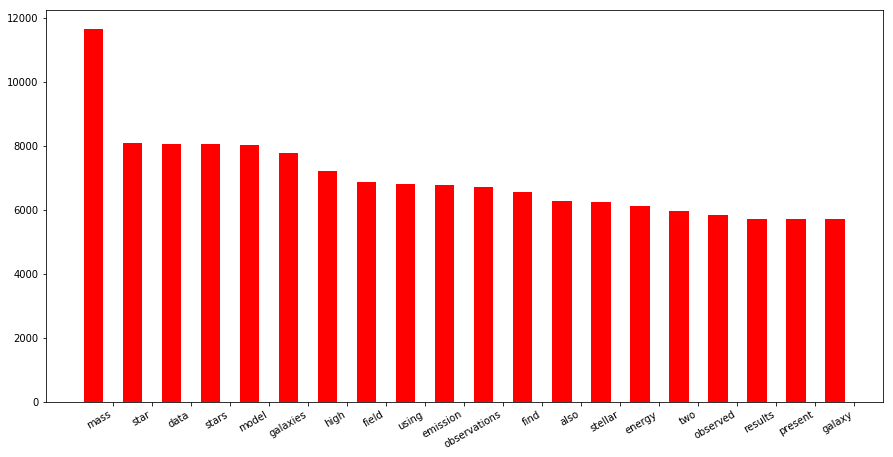

In [37]:
bar_chart(top_twenty)

In [38]:
new_top_twenty = Counter([s[0] for s in word_stems_list]).most_common(n=20)

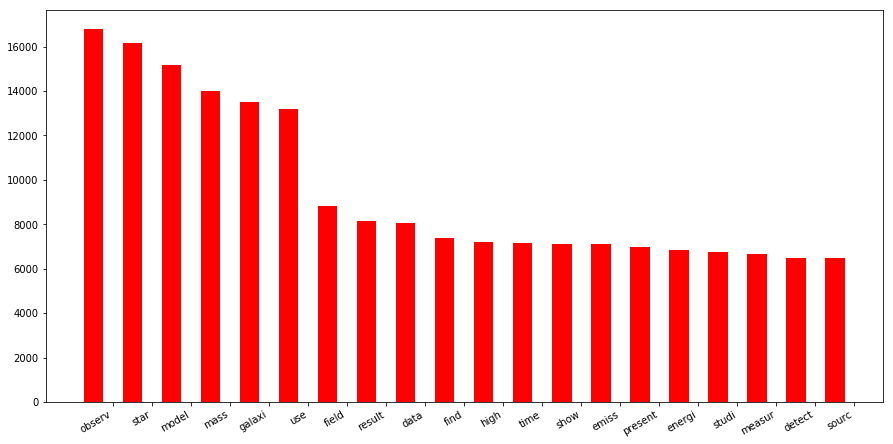

In [39]:
bar_chart(new_top_twenty)

In [40]:
stem2words['gravit']

{'gravit',
 'gravitates',
 'gravitating',
 'gravitation',
 'gravitational',
 'gravitationally',
 'gravitations'}

In [41]:
stem2words['rv']

{'rv', 'rvs'}

In [42]:
[s[0] for s in word_stems_list]

['investig',
 'role',
 'rotat',
 'instabl',
 'context',
 'black',
 'hole',
 'format',
 'relativist',
 'star',
 'addit',
 'standard',
 'scenario',
 'axial',
 'symmetr',
 'dynam',
 'instabl',
 'form',
 'horizon',
 'star',
 'center',
 'recent',
 'found',
 'low',
 'instabl',
 'shown',
 'lead',
 'fragment',
 'center',
 'horizon',
 'format',
 'differenti',
 'rotat',
 'star',
 'process',
 'might',
 'altern',
 'pathway',
 'produc',
 'smbh',
 'supermass',
 'star',
 'ineffici',
 'angular',
 'momentum',
 'transport',
 'valid',
 'often',
 'defin',
 'process',
 'determin',
 'degre',
 'model',
 'accur',
 'represent',
 'real',
 'world',
 'perspect',
 'intend',
 'use',
 'valid',
 'crucial',
 'industri',
 'govern',
 'depend',
 'increasingli',
 'predict',
 'comput',
 'model',
 'justifi',
 'decis',
 'articl',
 'survey',
 'model',
 'valid',
 'literatur',
 'propos',
 'formul',
 'valid',
 'iter',
 'construct',
 'process',
 'mimic',
 'process',
 'occur',
 'implicitli',
 'mind',
 'scientist',
 'thu',
 'offer'

In [43]:
len(stem2words)

20462

In [44]:
nltk.download()

NameError: name 'nltk' is not defined

In [45]:
len(string.punctuation)

32

In [46]:
spaces32 = " " * 32

In [47]:
spaces32

'                                '

In [48]:
df.keys()

Index(['title', 'abstract', 'categories', 'created', 'id', 'doi', 'label'], dtype='object')

In [49]:
df.title[100]

'Numerical Simulation of Excitation and Propagation of Helioseismic MHD\n  Waves in Magnetostatic Models of Sunspots'

In [50]:
title = 'x-ray binary'
title = re.sub(r"xX\-ray", 'xray', title)

In [51]:
title

'x-ray binary'

In [52]:
df

,title,abstract,categories,created,id,doi,label
0,Fragmentation of general relativistic quasi-to...,we investigate the role of rotational instabil...,"[gr-qc, astro-ph.HE]",2007-04-03,0704.0431,10.1142/9789812834300_0199,4.0
1,A General Strategy for Physics-Based Model Val...,validation is often defined as the process of ...,"[physics.comp-ph, astro-ph.EP, cond-mat.mtrl-s...",2007-10-01,0710.0317,None,3.0
2,The LSC Glitch Group : Monitoring Noise Transi...,the ligo scientific collaboration lsc glitch...,"[gr-qc, astro-ph.IM]",2008-04-04,0804.0800,10.1088/0264-9381/25/18/184004,2.0
3,Decaying Dark Matter and the Deficit of Dwarf ...,the hierarchical clustering inherent in lambda...,"[astro-ph, astro-ph.CO, gr-qc, hep-ph, hep-th]",2008-06-03,0806.0602,10.1111/j.1365-2966.2008.13530.x,5.0
4,A note on space dimensionality constraints rel...,a general sketch of how the problem of space d...,"[physics.hist-ph, astro-ph, astro-ph.GA]",2008-06-03,0806.0684,None,0.0
5,Neutrinos and Gamma Rays from Galaxy Clusters,the next generation of neutrino and gamma ray ...,"[astro-ph, astro-ph.GA, astro-ph.HE, hep-ph]",2008-07-04,0807.0794,10.1086/591723,0.0
6,Field Fractal Cosmological Model As an Example...,the idea of the global gravitational effect as...,"[gr-qc, astro-ph, astro-ph.CO]",2008-10-01,0810.0162,None,5.0
7,ARCADE 2 Measurement of the Extra-Galactic Sky...,the arcade instrument has measured the absolu...,[astro-ph.CO],2009-01-05,0901.0555,10.1088/0004-637X/734/1/5,5.0
8,Ionization of Infalling Gas,h alpha emission from neutral halo clouds prob...,[astro-ph.GA],2009-01-07,0901.0940,10.1051/eas/1256052,0.0
9,Secondary radio eclipse of the transiting plan...,we report the first attempt to observe the sec...,[astro-ph.EP],2009-01-15,0901.2344,10.1111/j.1365-2966.2009.14510.x,3.0


In [56]:
df.index

RangeIndex(start=0, stop=15842, step=1)

In [57]:
for i in df.index[:10]:
    print(i, df.label[i])

0 4.0
1 3.0
2 2.0
3 5.0
4 0.0
5 0.0
6 5.0
7 5.0
8 0.0
9 3.0


In [71]:
store = pd.HDFStore("astroph_2016_preprocessed.h5")
store['df'] = df
store.close()

/home/wklee/anaconda3/envs/tf-gpu-2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['title', 'abstract', 'categories', 'id', 'doi']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15842 entries, 0 to 15841
Data columns (total 7 columns):
title         15842 non-null object
abstract      15842 non-null object
categories    15842 non-null object
created       15842 non-null datetime64[ns]
id            15842 non-null object
doi           14028 non-null object
label         15842 non-null float64
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 866.4+ KB


In [73]:
store.open()

In [74]:
store.close()

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15842 entries, 0 to 15841
Data columns (total 7 columns):
title         15842 non-null object
abstract      15842 non-null object
categories    15842 non-null object
created       15842 non-null datetime64[ns]
id            15842 non-null object
doi           14028 non-null object
label         15842 non-null float64
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 866.4+ KB


In [76]:
len(df)

15842

In [77]:
# first 10 abstracts:
for i in range(10):
    print(df.at[i, "abstract"])
    print("\n")

we investigate the role of rotational instabilities in the context of black hole formation in relativistic stars  in addition to the standard scenario   an axially symmetric dynamical instability forming a horizon at the star s center   the recently found low   instabilities are shown to lead to fragmentation and off center horizon formation in differentially rotating stars  this process might be an alternative pathway to produce smbhs from supermassive stars with inefficient angular momentum transport 


validation is often defined as the process of determining the degree to which a model is an accurate representation of the real world from the perspective of its intended uses  validation is crucial as industries and governments depend increasingly on predictions by computer models to justify their decisions  in this article  we survey the model validation literature and propose to formulate validation as an iterative construction process that mimics the process occurring implicitly i